MPC for LTI systems and quadratic cost for regulation of the state to zero, with no reference tracking. This version is probably not very efficient but it is meant to be basic in order to show all steps of the design.

In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots 
import control as ct # control systems library
import cvxpy as cp
from collections import namedtuple
import time as tt

Utility functions

In [2]:
def terminal_cost_set(p):
    '''
    Computes an ellipsoidal terminal set x^T * Qt * x <= 1 and an associated terminal cost
    x^T * P * x, on the basis of a nominal controller computed with the same cost weights as the MPC problem
    p: MPC controller parameters
     '''
    # Terminal controller, computed as an LQR
    K, P, _ = ct.dlqr(p.A, p.B, p.Q, p.R)
    K = -K
    
    # State constraints under the nominal controller
    Z = np.vstack((p.F,p.E @ K))
    z = np.vstack((p.f, p.e))

    (nz, _) = Z.shape
    (n, _) = p.A.shape

    # Compute the maximal sublevel set of the terminal cost x^T * P * x
    # that lies within the constraints for the terminal controller
    a = cp.Variable(nz)
    gamma = cp.Variable(1)
    epsi = np.finfo(float).eps

    constraints = [gamma >= epsi]
    for i in range(nz):
        constraints += [a[i] >= epsi]
        M2 = cp.bmat([[gamma*P, np.zeros([n,1])],[np.zeros([1,n]), [[-1]]]])
        M1 = cp.bmat([[np.zeros([n,n]), 0.5*Z[i,:].reshape(1,-1).T], [0.5*Z[i,:].reshape(1,-1), -z[i,:].reshape(1,-1)]])
        constraints += [-a[i]*M1 + M2 >> 0]

    problem = cp.Problem(cp.Minimize(gamma), constraints)
    problem.solve(solver='MOSEK')
    if problem.status != 'optimal':
        raise(ValueError("Infeasible problem in terminal set"))
    else:
        # Terminal set x^T * Qt * x <= 1
        Qt = gamma.value * P
    
        return P, Qt

In [3]:
def sampled_data_controller(controller, plant_dt): 
    """
    Create a discrete-time system that models the behaviour 
    of a digital controller. 
    
    The system that is returned models the behavior of a sampled-data 
    controller, including a sampler and a ZOH converter. 
    The returned system is discrete-time, and its timebase `plant_dt` is 
    much smaller than the sampling interval of the controller, 
    `controller.dt`, to insure that continuous-time dynamics of the plant 
    are accurately simulated. This system must be interconnected
    to a plant with the same dt. The controller's sampling period must be 
    greater than or equal to `plant_dt`, and an integral multiple of it. 
    The plant that is connected to it must be converted to a discrete-time 
    ZOH equivalent with a sampling interval that is also `plant_dt`. A 
    controller that is a pure gain must have its `dt` specified (not None). 
    """
    # the following is used to ensure the number before '%' is a bit larger 
    one_plus_eps = 1 + np.finfo(float).eps 
    assert np.isclose(0, controller.dt*one_plus_eps % plant_dt), \
        "plant_dt must be an integral multiple of the controller's dt"
    nsteps = int(round(controller.dt / plant_dt))
    step = 0
    y = np.zeros((controller.noutputs, 1))

    def updatefunction(t, x, u, params):  
        nonlocal step

        # Update the controller state only if it is time to sample
        if step == 0:
            x = controller._rhs(t, x, u)
        step += 1
        if step == nsteps:
            step = 0

        return x
           
    def outputfunction(t, x, u, params):
        nonlocal y
        
        # Compute controller action if it is time to sample
        if step == 0:
            y = controller._out(t, x, u)       
        return y

    # Return the controller system object
    return ct.ss(updatefunction, outputfunction, dt=plant_dt, 
                 name=controller.name, inputs=controller.input_labels, 
                 outputs=controller.output_labels, states=controller.state_labels)

In [4]:
def quadratic_mpc_problem(p):
    """
    Generate a cvxpy problem for the quadratic MPC step
    p: Controller parameters
        A,B: Model
        N: Horizon length
        Q, R: State and input weights for stage cost
        P: Terminal cost weight
        Fx <= f: State constraints
        Eu <= e: Input constraints
        Qt: x^T * Qt * x <= 1 terminal constraint
    Parameters:
    x0: initial state
    returns cvxpy problem object with x0 as parameter
    """
    # State and input dimension
    (nx, nu) = p.B.shape

    # Define initial state as parameter  
    x0 = cp.Parameter(nx, name='x0')

    # Define state and input variables
    x = cp.Variable((nx, p.N + 1), name='x') # From k=0 to k=N
    u = cp.Variable((nu, p.N), name='u')     # From k=0 to k=N-1

    # Initialize cost and constraints
    cost = 0.0
    constraints = []
    
    # Generate cost and constraints
    for k in range(p.N):
        
        # Stage cost
        cost +=  cp.quad_form(x[:, k], p.Q)
        cost +=  cp.quad_form(u[:, k], p.R)

        # Dynamics constraint
        constraints += [x[:, k + 1] == p.A @ x[:, k] + p.B @ u[:, k]]

        # State constraints
        if p.F is not None:
            constraints += [p.F @ x[:, k] <= p.f.reshape(-1)]
        
    # Add terminal cost
    cost +=  cp.quad_form(x[:, p.N], p.P)
    
    # Terminal constraint: if unspecified, fall back to trivial terminal constraint
    if p.Qt is not None:
        constraints += [cp.quad_form(x[:, p.N], p.Qt) <= 1]
    else:
        constraints += [x[:, p.N] == np.zeros_like(x0) ]
    
    # Input constraints
    if p.E is not None:
        constraints += [p.E @ u <= p.e]  

    # Initial state constraint
    constraints += [x[:, 0] == x0]

    # Generate cvx problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    
    # Return problem object
    return problem

In [5]:
def mpc_controller(parameters, T, **kwargs):
        """
        Create an I/O system implementing an MPC controller
        parameters: Controller parameters
            A,B: Model
            N: Horizon length
            Q,R,P: Cost weights
        T: Sampling period
        """
    
        p = parameters
        nx, nu = p.B.shape
        ux = np.zeros((nu, 1))
    
        # Set up the cvxpy problem to be solved at each step
        problem = quadratic_mpc_problem(p)
      
        # State x of the MPC controller is the current optimal sequence
        # while its input u is composed by dummy inputs and current plant state
    
        # State update function
        def _update(t, x, u, params={}):
            nonlocal nu
            nonlocal p
            nonlocal problem
        
           
            # Retrieve current plant state
            x0 = u[-nx:]
            # Pass it as parameter to cvxpy
            problem.param_dict['x0'].value = x0
            # Solve optimization problem
            problem.solve(solver='MOSEK', warm_start=True)
            if problem.status != 'optimal':
                raise(ValueError("Infeasible problem"))
            else:
                # Retrieve solution (optimal sequence) and return it
                res = problem.var_dict['u'].value
                return res.reshape(-1)
                
        
        def _output(t, x, u, params={}):
            nonlocal nu
            nonlocal p
            nonlocal problem
            
            # Compute controller output

            # Retrieve plant state
            x0 = u[-nx:]
            # Pass it as parameter
            problem.param_dict['x0'].value = x0
            # Solve optimization problem
            problem.solve(solver='MOSEK', warm_start=True)
            if problem.status != 'optimal':
                raise(ValueError("Infeasible problem"))
            else:
                # Retrieve optimal sequence and return first sample as output
                res = problem.var_dict['u'].value
                return res[:,0]
                
        # Number of states of controller
        kwargs['states'] = nu * p.N
    
        return ct.NonlinearIOSystem(
            _update, _output, dt=T, **kwargs)

/Users/giannibi/anaconda3/envs/mpc/lib/python3.12/site-packages/cvxpy/expressions/constants/constant.py:53: UserWarning: Initializing a Constant with a nested list is undefined behavior. Consider using a numpy array instead.
  warnings.warn(NESTED_LIST_WARNING)
/Users/giannibi/anaconda3/envs/mpc/lib/python3.12/site-packages/mosek/__init__.py:18617: UserWarning: Argument sub in putvarboundlist: Incorrect array format causing data to be copied
  warnings.warn("Argument sub in putvarboundlist: Incorrect array format causing data to be copied");
/Users/giannibi/anaconda3/envs/mpc/lib/python3.12/site-packages/mosek/__init__.py:18925: UserWarning: Argument subj in putclist: Incorrect array format causing data to be copied
  warnings.warn("Argument subj in putclist: Incorrect array format causing data to be copied");
/Users/giannibi/anaconda3/envs/mpc/lib/python3.12/site-packages/mosek/__init__.py:18349: UserWarning: Argument sub in putconboundlist: Incorrect array format causing data to be c

'Simulation time:'

1.7850651741027832

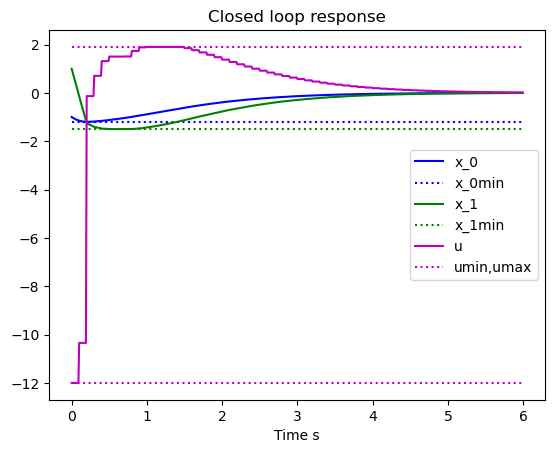

In [6]:
# Continuous-time plant model
A = np.array([[1, -1],
              [0, 1]])
B = np.array([[0],
              [1]])
C = np.array([[1, 0],
              [0, 1]])
D = np.array([[0],
              [0]])
plant_continuous = ct.ss(A,B,C,D, inputs='u', states=['x[0]','x[1]'], outputs=['x[0]','x[1]'])

# This is the step to simulate the continuous time plant (and the closed loop)
simulation_dt = 0.01
# Generate a discrete-time simulator of the plant with the simulation step
plant_simulator = ct.c2d(plant_continuous, simulation_dt, 'zoh')

# Controller sampling time
T = 0.1

# Generate discretized plant model for use with the controller
plant_discrete = ct.c2d(plant_continuous, T, 'zoh')

# MPC controller parameter structure field names
p = namedtuple('p', ['ndummyinputs', 'A', 'B','N','Q','R','P','F','f','E','e','Qt'])

# Cost weights
p.Q = np.array([[1, 0],[0, 1]])
p.R = np.array([[1]])

# Horizon length
p.N = 20

# Dummy input to make simulation function happy
p.dummyinputs = 1 # This is dummy

# Model
p.A = plant_discrete.A
p.B = plant_discrete.B

# State constraints
x_0min = -1.2
x_1min = -1.5 
x_0max = 1
x_1max = 1
p.F = np.array([[1,0],
                [0,1],
                [-1,0],
                [0,-1] ])
p.f = np.array([[x_0max],
                [x_1max],
                [-x_0min],
                [-x_1min] ])

# Input constraints
umin = -12
umax = 1.9
p.E = np.array([[1],
                [-1] ])
p.e = np.array([[umax],
                [-umin] ])


# Generate terminal cost and terminal set
p.P, p.Qt = terminal_cost_set(p)

# Plant state and input dimension
(nx,nu) = p.B.shape

# Define the MPC controller system object
controller = mpc_controller(p, T, inputs=['dummyinput','x[0]','x[1]'], outputs='u')

# Create model of controller for simulation with the same integration time
# as the plant
controller_simulator = sampled_data_controller(controller, simulation_dt)

# Compute closed loop. The closed loop state has nu*p.N states (the controller states)
# plus nx states (the plant simulator states)
closedloop_simulator = ct.interconnect([controller_simulator, plant_simulator], inputs=['dummyinput'], outputs=['x[0]', 'x[1]', 'u'],
                        states = nu*p.N + nx)

# Time vector for simulation
end_time = 6
time = np.arange(0, end_time, simulation_dt)

# Dummy input
dummyinput = np.zeros_like(time) 

# The controller state is the optimal input sequence: we initialize it to zero
initu = np.zeros(nu*p.N)

# Initial plant state
initx0 = np.array([-1,1])

# Closed loop initial state
initx = np.hstack((initu, initx0))

# Simulate
start_t = tt.time()
t, resp = ct.input_output_response(closedloop_simulator, time, dummyinput, initx)
stop_t = tt.time()
display("Simulation time:", stop_t - start_t)

# Plot responses
x_0, x_1, u = resp # extract responses
plt.plot(t, x_0, 'b-', label='x_0')
plt.plot(t, x_0min*np.ones_like(t), 'b:', label='x_0min')
plt.plot(t, x_1, 'g-', label='x_1')
plt.plot(t, x_1min*np.ones_like(t), 'g:', label='x_1min')
plt.plot(t, u, 'm-', label='u')
plt.plot(t, umax*np.ones_like(t), 'm:')
plt.plot(t, umin*np.ones_like(t), 'm:', label='umin,umax')
plt.xlabel("Time s")
plt.title("Closed loop response")
plt.legend()